In [1]:
from IPython.display import clear_output

# Install required libraries
!pip install bitsandbytes transformers trl peft datasets

!pip install -U ipywidgets



clear_output()

In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
import torch
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

2025-05-18 15:47:18.443979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-18 15:47:18.444118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 15:47:18.581516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Quantization settings for 4-bit training
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [4]:
!git clone https://github.com/Dehan001/Project-Bangla-Error-Correction-and-Classification

Cloning into 'Project-Bangla-Error-Correction-and-Classification'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 271 (delta 3), reused 267 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (271/271), 8.28 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/kaggle/working/Project-Bangla-Error-Correction-and-Classification/25,106_Dataset.csv')  # Adjusted file name
df = df.drop(columns=['Video ID', 'Time of Publishing', 'Title', 'Genre'], errors='ignore')

# Step 1: Split into train+val and test (e.g., 80% train+val, 20% test)
train_val, test = train_test_split(df, test_size=0.2, random_state=42)  # Use 'label' column if it exists

# Step 2: Split train_val into train and validation (e.g., 80% of train_val is train -> 64% total)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Check sizes
print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

# Save DataFrames to CSV
train.to_csv("train.csv", index=False)
val.to_csv("valid.csv", index=False)
test.to_csv('test.csv',index=False)

train.head()

Train size: 15063
Validation size: 5021
Test size: 5022


,Comment,corrected_text,generated_reason
1773,ম্যাচিউর হওয়ার সাথে সাথে পুরাতন গান গুলাও বেশি...,ম্যাচিউর হওয়ার সাথে সাথে পুরাতন গানগুলোও বেশি ...,গান গুলাও-গানগুলোও।
3627,৮ বছর থেকে শুনছি কখনো এতোটুকু বিরক্তি আসে নাই,"৮ বছর ধরে শুনছি, কখনো এতটুকু বিরক্তি আসে নি।","থেকে - ধরে, এতোটুকু - এতটুকু, আসে নাই - আসে নি।"
14724,এইসব ডায়লগ না জানা আমি😂,এইসব ডায়লগ আমার জানা নেই।/ এইসব ডায়লগ আমার জান...,না জানা আমি - আমার জানা নেই/ আমার জানা ছিল না।
22350,নাটক টা দেখে চখে পানি ধরে রাখতে পারলাম না 😢😢,নাটকটা দেখে চোখে পানি ধরে রাখতে পারলাম না। 😢😢,"টা - টা, চখে - চোখে।"
12031,সত্যিই সততা এমনি হওয়া উচিত,সত্যিই সততা এমনই হওয়া উচিত।,এমনি - এমনই।


In [6]:
from datasets import load_dataset
import pandas as pd



# Load dataset from CSV files
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'valid': 'valid.csv', 'test':'test.csv'})

# Convert specific columns to string
def convert_to_string(example):
    example['input'] = str(example['Comment'])
    example['output'] = str(example['corrected_text'])
    example['reason'] = str(example['generated_reason'])
    return example

# Apply transformation
dataset['train'] = dataset['train'].map(convert_to_string)
dataset['valid'] = dataset['valid'].map(convert_to_string)
dataset['test'] = dataset['test'].map(convert_to_string)

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15063 [00:00<?, ? examples/s]

Map:   0%|          | 0/5021 [00:00<?, ? examples/s]

Map:   0%|          | 0/5022 [00:00<?, ? examples/s]

In [7]:
len(dataset['train']['input'])

15063

In [8]:
# 3. SFT Training Phase (PEFT with LoRA)
def run_sft(train_data, valid_data):
    print("➡️ Starting SFT phase...")
    
    # Load model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(
        "/kaggle/input/qwen2.5/transformers/1.5b/1",
        quantization_config=quantization_config,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen2.5/transformers/1.5b/1")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Prepare model for PEFT
    model = prepare_model_for_kbit_training(model)
    
    # LoRA configuration
    peft_config = LoraConfig(
        r=8,  # Rank
        lora_alpha=32,  # Scaling factor
        lora_dropout=0.1,  # Dropout
        target_modules=["q_proj", "v_proj"],  # Target modules
        bias="none",  # Bias setting
        task_type="CAUSAL_LM"  # Task type
        
    )
    
    # Apply LoRA to the model
    model = get_peft_model(model, peft_config)
    
    # Training arguments
    training_args = SFTConfig(
        output_dir="./sft_results",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        learning_rate=0.0001,
        max_steps=300,  # Reduced steps for quick testing
        logging_steps=1,
        eval_strategy="no",  # No evaluation
        fp16=True,
        report_to="none",
        max_seq_length=512,
        eos_token="<|im_end|>",
    )


    def format_sft_data(example):
        return f"### Instruction: Identify and correct the grammatical errors and mention the reasons for these errors.\n ### Input: {example['Comment']}\n ### Output:\n{example['corrected_text']}\n Reason:\n{example['generated_reason']}"
    


    
    # SFT Trainer
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset = valid_data,
        formatting_func=format_sft_data,
        processing_class=tokenizer,  # Use tokenizer for processing
        data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    )
    
    # Set tokenizer padding side to 'right'
    trainer.processing_class.padding_side = 'right'
    
    # Start training
    print("➡️ Starting SFT training...")
    trainer.train()
    trainer.save_model("./sft_model")
    print("✅ SFT phase complete.")
    return model, tokenizer

In [9]:
# 2. Data Preparation
class HFDataCurator:
    def __init__(self, max_samples=5000):
        print("➡️ Preparing data...")
        # Load SFT dataset
        self.train_data = dataset['train']
        self.valid_data = dataset['valid']
        # Format the data
        # self.train_data = self.train_data.map(DataFormatter.format_sft)
        # self.valid_data = self.valid_data.map(DataFormatter.format_sft)
        print("✅ Data preparation complete.")

In [10]:
curator = HFDataCurator()
curator.train_data

➡️ Preparing data...
✅ Data preparation complete.


Dataset({
    features: ['Comment', 'corrected_text', 'generated_reason', 'input', 'output', 'reason'],
    num_rows: 15063
})

In [11]:
curator.train_data[:5]

{'Comment': ['ম্যাচিউর হওয়ার সাথে সাথে পুরাতন গান গুলাও বেশি ভালো লাগা শুরু হচ্ছে 🙂',
  '৮ বছর থেকে শুনছি কখনো এতোটুকু বিরক্তি  আসে নাই',
  'এইসব ডায়লগ না জানা আমি😂',
  'নাটক টা দেখে চখে পানি ধরে রাখতে পারলাম না 😢😢',
  'সত্যিই সততা এমনি হওয়া উচিত'],
 'corrected_text': ['ম্যাচিউর হওয়ার সাথে সাথে পুরাতন গানগুলোও বেশি ভালো লাগা শুরু হচ্ছে 🙂',
  '৮ বছর ধরে শুনছি, কখনো এতটুকু বিরক্তি আসে নি।',
  'এইসব ডায়লগ আমার জানা নেই।/ এইসব ডায়লগ আমার জানা ছিল না।',
  'নাটকটা দেখে চোখে পানি ধরে রাখতে পারলাম না। 😢😢',
  'সত্যিই সততা এমনই হওয়া উচিত।'],
 'generated_reason': ['গান গুলাও-গানগুলোও।',
  'থেকে - ধরে, এতোটুকু - এতটুকু, আসে নাই - আসে নি।',
  'না জানা আমি - আমার জানা নেই/ আমার জানা ছিল না।',
  'টা - টা, চখে - চোখে।',
  'এমনি - এমনই।'],
 'input': ['ম্যাচিউর হওয়ার সাথে সাথে পুরাতন গান গুলাও বেশি ভালো লাগা শুরু হচ্ছে 🙂',
  '৮ বছর থেকে শুনছি কখনো এতোটুকু বিরক্তি  আসে নাই',
  'এইসব ডায়লগ না জানা আমি😂',
  'নাটক টা দেখে চখে পানি ধরে রাখতে পারলাম না 😢😢',
  'সত্যিই সততা এমনি হওয়া উচিত'],
 'output': ['ম্যা

In [12]:
# Main Execution Flow
if __name__ == "__main__":
    print("➡️ Starting workflow...")
    
    # 1. Data Preparation
    curator = HFDataCurator()
    
    # 2. SFT Phase
    # sft_model, sft_tokenizer = run_sft(curator.train_data, curator.valid_data)
    sft_model, sft_tokenizer = run_sft(dataset['train'], dataset['valid'])
    
    # 3. Save the final model
    print("➡️ Saving the final model...")
    sft_model.save_pretrained("./final_sft_model")
    sft_tokenizer.save_pretrained("./final_sft_model")
    print("✅ Final model and tokenizer saved.")
    
    print("✅ All tasks completed successfully.")

➡️ Starting workflow...
➡️ Preparing data...
✅ Data preparation complete.
➡️ Starting SFT phase...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Applying formatting function to train dataset:   0%|          | 0/15063 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/15063 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/15063 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/15063 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15063 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/5021 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/5021 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/5021 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5021 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5021 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


➡️ Starting SFT training...


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,1.385600
2,1.627600
3,1.778100
4,1.427900
5,1.281900
6,1.235500
7,1.276300
8,1.454100
9,1.469600
10,1.335800


✅ SFT phase complete.
➡️ Saving the final model...
✅ Final model and tokenizer saved.
✅ All tasks completed successfully.


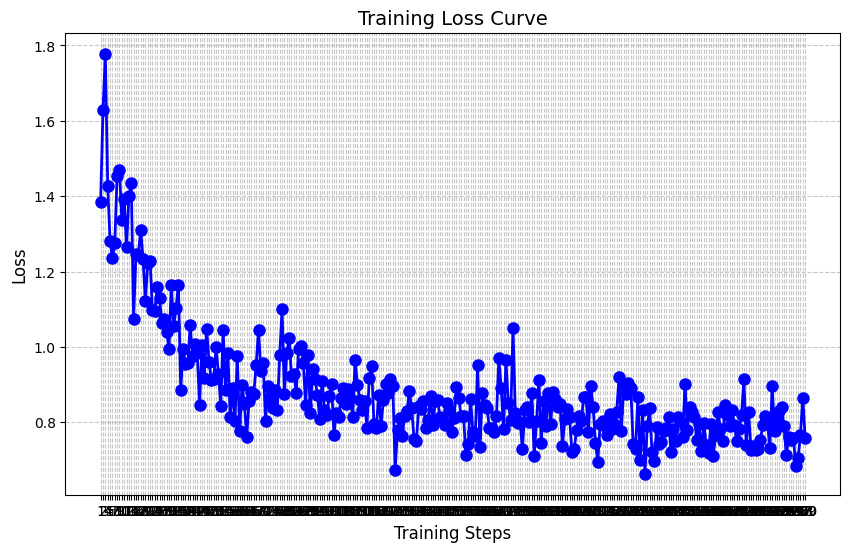

In [13]:
import matplotlib.pyplot as plt
import json

# 1. Load training logs
log_path = "/kaggle/working/sft_results/checkpoint-300/trainer_state.json"  # Path to your training logs

with open(log_path, "r") as f:
    training_logs = json.load(f)

# 2. Extract loss values and steps
loss_history = [entry["loss"] for entry in training_logs["log_history"] if "loss" in entry]
steps = [entry["step"] for entry in training_logs["log_history"] if "loss" in entry]

# 3. Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_history, 'b-o', linewidth=2, markersize=8)
plt.title("Training Loss Curve", fontsize=14)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(steps)
plt.show()

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
import torch

# 1. Load Model and Tokenizer with Quantization
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/qwen2.5/transformers/1.5b/1",
    quantization_config=quant_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained("./final_sft_model")
model = PeftModel.from_pretrained(base_model, "./final_sft_model")

# 2. Inference Function with Error Handling
def correct_bangla_text(input_text, max_length=512):
    """
    Corrects grammatical errors in Bangla text using the fine-tuned model
    Returns: (corrected_text, reasoning)
    """
    try:
        # Format input according to training template
        prompt = f"Identify and correct the grammatical errors and mention the reasons for these errors. \nInput: {input_text}"
        
        # Tokenize input
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
            return_attention_mask=True
        ).to(model.device)
        
        # Generate response
        outputs = model.generate(
            **inputs,
            max_new_tokens=400,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        
        # Decode and extract response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        
        return full_response
    
    except Exception as e:
        return f"Error: {str(e)}", ""

In [15]:
import re
import tqdm

# Regex patterns to extract Input, Corrected Output, and Reason
input_pattern = r"Input:\s*(.*)"
corrected_output_pattern = r"Output:\s*(.*)"
reason_pattern = r"Reason:\s*(.*)"

input_list = []
corrected_output_list = []
reason_output_list = []

test_cases = dataset['test']['input'][:200]

for text in tqdm.tqdm(test_cases):
    corrected = correct_bangla_text(text)
    # print(corrected)
    
    try:
        input_text = re.search(input_pattern, corrected).group(1).strip()
    except AttributeError:
        input_text = "N/A"  # Default value if no match is found
    
    try:
        corrected_output = re.search(corrected_output_pattern, corrected).group(1).strip()
    except AttributeError:
        corrected_output = "N/A"
    
    try:
        reason_output = re.search(reason_pattern, corrected).group(1).strip()
    except AttributeError:
        reason_output = "N/A"
    
    input_list.append(input_text)
    corrected_output_list.append(corrected_output)
    reason_output_list.append(reason_output)

100%|██████████| 200/200 [1:08:28<00:00, 20.54s/it]


In [16]:
import pandas as pd
# Prepare data for DataFrame
data = {
    "Input": input_list,
    "Corrected Output": corrected_output_list,
    "Reason": reason_output_list
}


# Create a DataFrame
df = pd.DataFrame(data)

# Write to CSV file
csv_file = "extracted_data.csv"
df.to_csv(csv_file, index=False, encoding="utf-8")

print(f"Data has been written to {csv_file}")

Data has been written to extracted_data.csv


In [17]:
df.head()

,Input,Corrected Output,Reason
0,যার জন্য নিজেকে বদলাতে চেয়েছিলাম সে আজ নিজেই...,"For this task, I will identify and correct any...",N/A
1,আমি তুমাকে ভালবাসি গৌরী সুন্দরী 😍🥀,"আমি তুমাকে ভালবাসি, গৌরী সুন্দরী।",N/A
2,"👉আপনাদের ভিডিও গুলো খুব ভালো লাগে,,, আমার চ্যা...",✍️ ​​​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​...,N/A
3,বাংলাদেশের মানুষএর শিক্ষার হার আরো বেশি হওয়ার...,The sentence is already free of any grammatica...,No changes needed as the sentence seems to be ...
4,Plank constant এর একটা ভিডিও দিবেন ভাইয়া প্লি...,"Plank's constant will be shared with you, dear.",N/A
